In [9]:
import sys
sys.path.append('../')

import numpy as np
import legume
from legume import viz

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Reproduce Fig. 1(b) in Cerjan and Fan, PRA (2017)

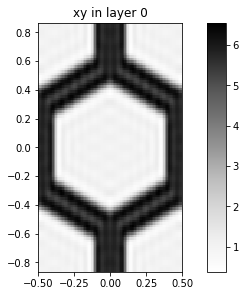

In [11]:
# Initialize a lattice
lattice = legume.Lattice('hexagonal')
# Initialize a layer
layer = legume.ShapesLayer(lattice, eps_b = 2.4**2)
# Add a shape to this layer 
l = 1/np.sqrt(3) # l-parameter in his paper in units of lattice constant a (which is a = 1 in my case)
hexagon = legume.Hexagon(eps = 1, a = (1-0.1818*l)/2)
hexagon.rotate(np.pi/6)
layer.add_shape(hexagon)

# Initialize the PWE 
pwe = legume.PlaneWaveExp(layer, gmax=5)
viz.structure_ft(pwe)

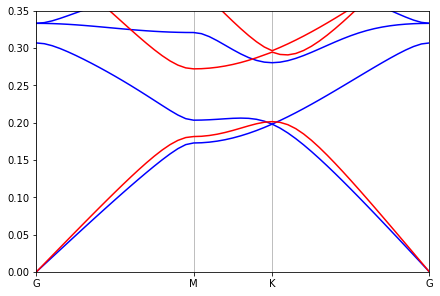

In [12]:
path = layer.lattice.bz_path(['G', 'M', 'K', 'G'], [20, 10, 20])

# Now we can run the PWE for both polarizations
pwe.run(kpoints=path.kpoints, pol='te')
freqs_te = pwe.freqs
pwe.run(kpoints=path.kpoints, pol='tm')
freqs_tm = pwe.freqs

# And plot the results!
fig, ax = plt.subplots(1, constrained_layout=True)
plt.plot(freqs_tm*l, 'b')
plt.plot(freqs_te*l, 'r')
ax.set_ylim([0, 0.35])
ax.set_xlim([0, pwe.freqs.shape[0]-1])
plt.xticks(path.pt_inds, path.pt_labels)
ax.xaxis.grid('True')
plt.show()

## Optimize the band gap with a supercell and autograd

In [28]:
import autograd.numpy as npa
from autograd import grad, value_and_grad
legume.set_backend('autograd')

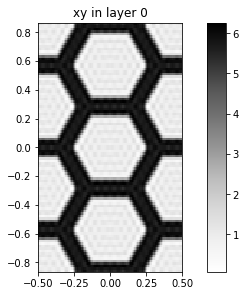

In [16]:
def pwe_cerjan(params, gmax=10):
    # Make a PWE simulation with 3 holes in the elementary cell
    # Initialize a lattice
    lattice = legume.Lattice('hexagonal')
    # Initialize a layer
    layer = legume.ShapesLayer(lattice, eps_b = 2.4**2)
    a_sc = np.sqrt(3)
    hex1 = legume.Hexagon(eps=1, a = params[0]/a_sc)
    hex2 = legume.Hexagon(eps=1, x_cent=np.sqrt(3)/2/a_sc, y_cent=0.5/a_sc, a=params[1]/a_sc)
    hex3 = legume.Hexagon(eps=1, x_cent=np.sqrt(3)/2/a_sc, y_cent=-0.5/a_sc, a=params[2]/a_sc)
    # Make a supercell
    layer.add_shape(hex1, hex2, hex3)
    
    return legume.PlaneWaveExp(layer, gmax=gmax)

# Initialize the PWE that should match the simulation above
l = 1/np.sqrt(3)
params = np.ones(3)*(1-0.1818*l)/2
pwe = pwe_cerjan(params)
viz.structure_ft(pwe)

## Reproduce Fig. 1(d) in Cerjan and Fan, PRA (2017)

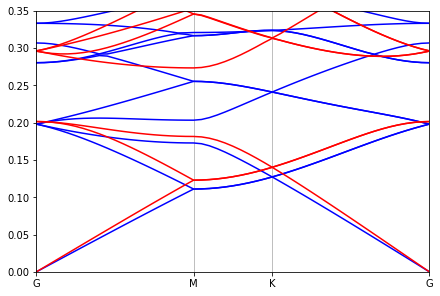

In [17]:
path = layer.lattice.bz_path(['G', 'M', 'K', 'G'], [20, 10, 20])

# Now we can run the PWE for both polarizations
pwe.run(kpoints=path.kpoints, pol='te')
freqs_te = pwe.freqs
pwe.run(kpoints=path.kpoints, pol='tm')
freqs_tm = pwe.freqs

# And plot the results!
fig, ax = plt.subplots(1, constrained_layout=True)
plt.plot(freqs_tm/3, 'b')
plt.plot(freqs_te/3, 'r')
ax.set_ylim([0, 0.35])
ax.set_xlim([0, pwe.freqs.shape[0]-1])
plt.xticks(path.pt_inds, path.pt_labels)
ax.xaxis.grid('True')
plt.show()

## Reproduce something like Fig. 1(f) in Cerjan and Fan, PRA (2017)

[0.38 0.53 0.53]


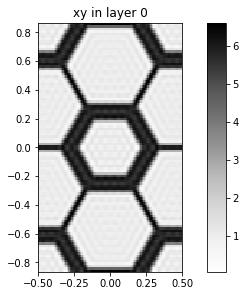

In [19]:
params = np.array([0.38, 0.53, 0.53])
print(params)
pwe = pwe_cerjan(params, gmax=10)
viz.structure_ft(pwe)

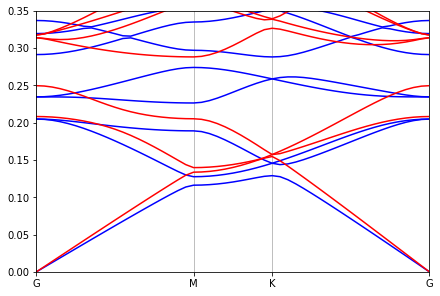

In [20]:
path = layer.lattice.bz_path(['G', 'M', 'K', 'G'], [20, 10, 20])

# Now we can run the PWE for both polarizations
pwe.run(kpoints=path.kpoints, pol='te')
freqs_te = pwe.freqs
pwe.run(kpoints=path.kpoints, pol='tm')
freqs_tm = pwe.freqs

# And plot the results!
fig, ax = plt.subplots(1, constrained_layout=True)
plt.plot(freqs_tm/3, 'b')
plt.plot(freqs_te/3, 'r')
ax.set_ylim([0, 0.35])
ax.set_xlim([0, pwe.freqs.shape[0]-1])
plt.xticks(path.pt_inds, path.pt_labels)
ax.xaxis.grid('True')
plt.show()

In [21]:
# Function to return the band-gap size around a given center frequency
def bg_size(freqs_te, freqs_tm, freq_cent = 0.29*3):
    freqs_all = npa.hstack((freqs_te.flatten(), freqs_tm.flatten()))
    freq_min = npa.amax(npa.where(freqs_all < freq_cent, freqs_all, 0))
    freq_max = npa.amin(npa.where(freqs_all > freq_cent, freqs_all, 1e6))
    return freq_max - freq_min

print('Band gap size:', bg_size(freqs_te, freqs_tm)) 

Band gap size: 0.0016516107560572424


In [40]:
def of_bg(ps):
    # Initialize the PWE 
    pwe = pwe_cerjan([ps[0], ps[1], ps[2]])

    # Run the PWE for both polarizations
    pwe.run(kpoints=path.kpoints, pol='te')
    freqs_te = pwe.freqs
    pwe.run(kpoints=path.kpoints, pol='tm')
    freqs_tm = pwe.freqs
    
    # And return the band gap size as objective function
    # We sample several different center frequencies and take the largest bandgap found
    cfs = npa.arange(0.25, 0.32, 0.01)*3
    bgs = []
    for cf in cfs:
        bg = bg_size(freqs_te, freqs_tm, freq_cent=cf)
        bgs.append(bg)

    return -npa.amax(npa.array(bgs))

In [50]:
# Let's first test the gradient
from legume.utils import grad_num 
grad_test = grad(of_bg)
obj_grad = value_and_grad(of_bg)
print(of_bg(params))

print('Autograd gradient:  ', grad_test(params))
print('Numerical gradient: ', grad_num(of_bg, params, 1e-5))

-0.02107053641357759
Autograd gradient:   [ 0.41235621 -0.71463875 -0.69204414]
Numerical gradient:  [ 0.41302741 -0.7149465  -0.69279374]


In [25]:
from legume.minimize import Minimize

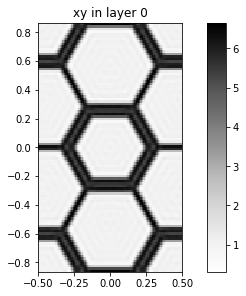

In [49]:
# Pick some starting point and show what the supercell is about
params = np.array([0.42, 0.52, 0.53])
pwe = pwe_cerjan(params)
viz.structure_ft(pwe)

In [51]:
# Run the optimization
opt = Minimize(obj_grad, True)
(p_opt, ofs) = opt.lbfgs(params, Nepochs = 20, disp_p = True, bounds = [0.1, 0.6])

Epoch:    1/  20 | Duration:   4.78 secs | Objective: -3.976199e-02 | Parameters: [0.38161991 0.52959502 0.53839564]
Epoch:    2/  20 | Duration:  11.31 secs | Objective: -4.213667e-02 | Parameters: [0.38226777 0.52639748 0.53427706]
Epoch:    3/  20 | Duration:  22.85 secs | Objective: -4.214616e-02 | Parameters: [0.38228808 0.5263842  0.53426052]
Epoch:    4/  20 | Duration:  27.70 secs | Objective: -4.214654e-02 | Parameters: [0.3822884  0.52638359 0.53425987]
Epoch:    5/  20 | Duration:   1.59 secs | Objective: -4.238796e-02 | Parameters: [0.37542441 0.52541055 0.53341616]
Epoch:    6/  20 | Duration:   1.56 secs | Objective: -4.239114e-02 | Parameters: [0.37477101 0.52534815 0.53330604]
Epoch:    7/  20 | Duration:   1.62 secs | Objective: -4.244479e-02 | Parameters: [0.37462836 0.52723183 0.53143894]
Epoch:    8/  20 | Duration:   1.61 secs | Objective: -4.245743e-02 | Parameters: [0.37469435 0.52870731 0.53002256]
Epoch:    9/  20 | Duration:   4.78 secs | Objective: -4.245911e

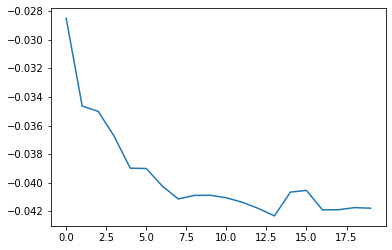

In [36]:
import matplotlib.pyplot as plt
plt.plot(ofs)
plt.show()

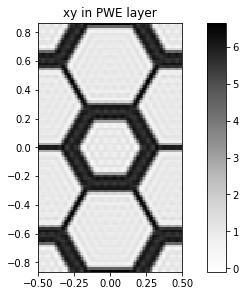

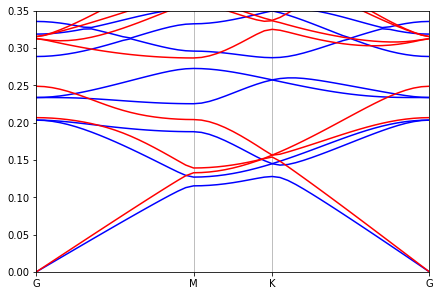

In [19]:
pwe = pwe_cerjan(p_opt)
viz.structure_ft(pwe)

# Now we can run the PWE for both polarizations
pwe.run(kpoints=path.kpoints, pol='te')
freqs_te = pwe.freqs
pwe.run(kpoints=path.kpoints, pol='tm')
freqs_tm = pwe.freqs

# And plot the results!
fig, ax = plt.subplots(1, constrained_layout=True)
plt.plot(freqs_tm/3, 'b')
plt.plot(freqs_te/3, 'r')
ax.set_ylim([0, 0.35])
ax.set_xlim([0, pwe.freqs.shape[0]-1])
plt.xticks(path.pt_inds, path.pt_labels)
ax.xaxis.grid('True')
plt.show()